##*Setup Environment*

This is an impomplete version that need to be inserted in the user interface. It can be used under a non python environment.

Please click the buttons on the upper left corner of each box to realize the operation for each step.

Please click the directory in the upper left of this page to go to subdirectorys.

Sentances start with # stand for remarks or abandoned codes. 

Please feel free to make any changes, or add any notes. A copy has been saved : )

To uncomment a block of code, please select the code and use "command"+"/".


In [45]:
# !pip install scipy.stats 
# !pip install datetime
# !pip install numpy
# !pip install pandas
# !pip install matplotlib.pyplot
# !pip install yfinance
# !pip install statistics
# !pip install pandas_datareader

In [46]:
# !pip install PyPortfolioOpt

In [10]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import datetime as dt
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
import statistics

In [11]:
import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter

##*Monte Carlo Simulation*

In [4]:
stock_list = ['TSLA']   #select your underlying stock here
strike_price = [155,157,162]   #enter strike price of call
stock_weight = 0.3
option_weight = [0.2,0.3,0.2]
r = 0.05   #enter riskfree rate
T = 1 #time in years
N = 1000 #number of steps within each simulation
i = 1000 #number of simulations
discount_factor = np.exp(-r*T)

In [5]:
#calculate the volatility of stock
today = datetime.now()
one_year_ago = today.replace(year=today.year-1)

def get_data(stock, one_year_ago, today):
    # Retrieve stock data
    yf.pdr_override()
    df = yf.download(stock, start=one_year_ago, end=today)
    df = df.sort_values(by="Date")
    df = df.dropna()
    df = df.assign(close_day_before=df.Close.shift(1))
    return df
    
def calculate_sigma(stock, one_year_ago, today):
    df = get_data(stock, one_year_ago, today)
    df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)
    sigma = np.sqrt(252) * df['returns'].std()
    return sigma

# for stock in stock_list:
#     sigma = calculate_sigma(stock, one_year_ago, today)
#     print(f"Stock: {stock}, Sigma: {sigma}")
    

In [6]:
#Monte Carlo simulation 

def geometric_brownian(S0,T,N,i,r,sigma,stock, one_year_ago, today):
    deltat = T/N #time step
    stock_prices = np.zeros([i,N])
    t = range(0,N,1)
    
    S = np.zeros([i,N])
    sigma=sigma/np.sqrt(1000)
    for y in range(0,i-1):
        S[y,0]=S0
        for x in range(0,N-1):
            S[y,x+1] = S[y,x]*(np.exp((r/1000-sigma**2/2)*deltat + sigma*deltat*np.random.normal(0,1)))#Brownian Motion Process with Drift
    return S


def plot(S, i, N, sigma, r, S0):
    t = range(0,N,1)
    for y in range(0,i-1):
        plt.plot(t, S[y])

    plt.title('Simulations %d Steps %d Sigma %.2f r %.2f S0 %.2f' % (i, N, sigma, r, S0))
    plt.xlabel('Steps')
    plt.ylabel('Stock Price')
    plt.show()



In [7]:
for stock in stock_list:         
    df = get_data(stock, one_year_ago, today)
    S0 = df.iloc[-1]['Close'] #initial stock price = current Close price 
    sigma=calculate_sigma(stock, one_year_ago, today)
    S = geometric_brownian(S0, T, N, i, r, sigma, stock, one_year_ago, today)
    plot(S, i, N, sigma, r, S0)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TSLA: No data found for this date range, symbol may be delisted


IndexError: single positional indexer is out-of-bounds

In [8]:
def call(S,i,N,K):
    C = np.zeros((i-1,1), dtype=np.float16)
    for y in range(0,i-1):
        C[y]=np.maximum(S[y,N-1]-K,0)
    return C

def put(S,i,N,K):
    P = np.zeros((i-1,1), dtype=np.float16)
    for y in range(0,i-1):
        P[y]=np.maximum(K-S[y,N-1],0)
    return P

def option_payoff(discount_factor,O):
    Payoff = discount_factor*O
    return Payoff 

# def plot_portfolio(S, i, N, stock, strike):
#     t = range(0,N,1)
#     for y in range(0,i):
#         plt.plot(t, S)

#     plt.title('Stock %s Strike Price %s Sigma %.2f r %.2f' % (stock, strike, sigma, r))
#     plt.xlabel('t')
#     plt.ylabel('Portfolio')
#     plt.show()

In [9]:
option_portfolio = np.zeros((i-1, 1))

df = get_data(stock, one_year_ago, today)
S0 = df.iloc[-1]['Close'] #initial stock price = current Close price 
sigma=calculate_sigma(stock, one_year_ago, today)
S = geometric_brownian(S0, T, N, i, r, sigma, stock, one_year_ago, today)

def option_value(S,i,N,strike,discount_factor,j):
    for j, strike in enumerate(strike_price):
        for y in range(i-1):
            C = call(S,i,N,strike)     
            C_payoff = option_payoff(discount_factor,C)
        print("\nThe payoff of %s 's call with strike price of %.2f is %.2f." % (stock_list, strike, C_payoff[y]))
        return
        option_portfolio += option_weight[j]*C_payoff
#     print("\nThe payoff of %s 's put with strike price of %.2f is %.2f." % (stock_list, strike, P_payoff[y]))


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TSLA: No data found for this date range, symbol may be delisted


IndexError: single positional indexer is out-of-bounds

[56.64124146 56.6415977  56.64251581 56.64227231 56.64161019 56.64192951
 56.64212554 56.6395216  56.63874675 56.63928012 56.63996969 56.63795235
 56.64132369 56.64118418 56.64089896 56.63951355 56.63938343 56.63844037
 56.63889623 56.63925605 56.63860612 56.63753181 56.63581085 56.63416894
 56.63397675 56.6345979  56.63541154 56.63508295 56.6339633  56.63382586
 56.63341767 56.63422606 56.63437644 56.63609644 56.63694178 56.63731754
 56.63750018 56.63734813 56.63907027 56.64004481 56.64010809 56.63936252
 56.63896227 56.63775138 56.63801298 56.63749217 56.63698292 56.63724468
 56.63560282 56.63414546 56.63416241 56.6320888  56.63204125 56.63210291
 56.6316452  56.63253748 56.63213662 56.63415655 56.63467833 56.63455586
 56.63397899 56.63393497 56.63314059 56.63294231 56.63441709 56.63490989
 56.63300234 56.63380216 56.63535112 56.63601118 56.63614151 56.63527029
 56.63470148 56.63410275 56.63358913 56.63415214 56.63586448 56.63702701
 56.63717426 56.63809705 56.63799888 56.63759635 56

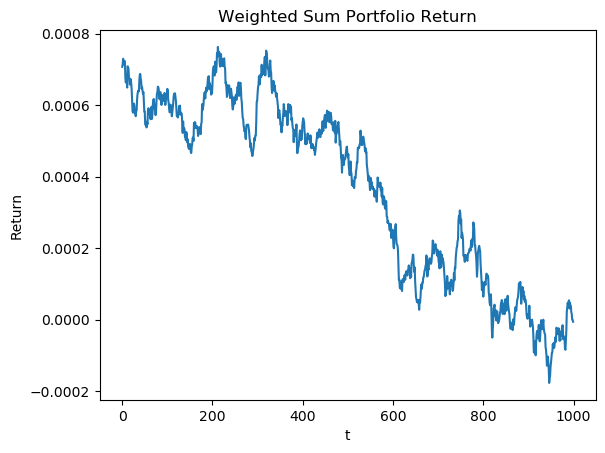

In [44]:
# calculate portfolio return

weighted_sum_portfolio = stock_weight*S[y] + (1-stock_weight)*option_portfolio[y]
print(weighted_sum_portfolio)
for y in range(0,i-1):
    
    portfolio_return = (weighted_sum_portfolio - weighted_sum_portfolio[y-1]) / weighted_sum_portfolio[y-1]
    average_return = np.average(portfolio_return)
    confidence_level = 0.95
    sorted_returns = np.sort(portfolio_return)
    var_position = int(len(sorted_returns) * (1 - confidence_level))
    var = sorted_returns[var_position]

print(f"\nAverage return of the portfolio is: {average_return*100}% ")
print(f"\nVaR of the portfolio at {confidence_level*100}% confidence level: {var}")


plt.plot(portfolio_return)
plt.title('Weighted Sum Portfolio Return')
plt.xlabel('t')
plt.ylabel('Return')
plt.show()


In [ ]:
var_min = np.zeros(i)
var_max = np.zeros(i)

# calculate max and min VaR
for y in range(i):
    portfolio_returns_sorted = np.sort(portfolio_returns[y])
    var_index_min = int(N * 0.05)  # 
    var_index_max = int(N * 0.95)  # 
    var_min[y] = portfolio_returns_sorted[var_index_min]
    var_max[y] = portfolio_returns_sorted[var_index_max]

##*VaR,CVaR Calculation*

In [14]:
def mcVaR(returns, alpha):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha):
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [34]:
portResults = pd.Series(Portfolio)

initialPortfolio = S0

VaR = initialPortfolio - mcVaR(portResults, 5)
CVaR = initialPortfolio - mcCVaR(portResults, 5)

print('VaR ${:,.2f}'.format(VaR,2))
print('CVaR ${:,.2f}'.format(CVaR,2))

VaR $-202.00
CVaR $-201.02


##*Monte Carlo Simulation of VaR*

In [ ]:
history

history
